# Testing kmeans method with image frames (16x16)

## Loading the image 

In [2]:
import commonmethods.image_modification as im

image = im.load_image_grayscale('5')

resized_image = im.resize_image(image, 1024)

## Method for getting the image frame, size: 16x16

In [5]:
from matplotlib import pyplot as plt
import numpy as np

def get_frame(row_number, column_number):
    frame = np.zeros((16, 16, 3))

    for i in range(0, 16):
        column = np.zeros((16, 3))
        for j in range(0, 16):
            column[j] = resized_image[row_number+i][column_number+j]
        frame[i] = column
    
    return frame

## Testing the above method and plotting the frame

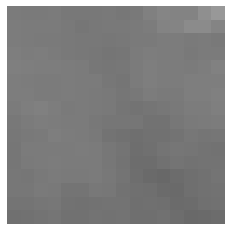

In [6]:
from matplotlib import pyplot as plt

result_frame = get_frame(720, 780)

plt.axis("off")

plt.imshow(result_frame.astype(np.uint8))

## Tetsing the kmeans to different frames

In [5]:
import cv2

frame1 = get_frame(658, 557)
frame1 = frame1.reshape((1, -1))
frame2 = get_frame(354, 610)
frame2 = frame2.reshape((1, -1))

Z = np.vstack((frame1,frame2,frame1, frame2, frame2, frame1))

values = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_images = centers[labels.flatten()]

#segmented_images = np.vsplit(segmented_images, 3)

print(labels)

[0 1 0 1 1 0]


In [6]:
import cv2

frame_avokado1 = get_frame(658, 557)
frame_avokado2 = get_frame(595, 600)
frame_background = get_frame(354, 610)
frame_vase1 = get_frame(600, 360)
frame_vase2 = get_frame(700, 320)
frame_paprika = get_frame(720, 780)

frame_avokado1 = frame_avokado1.reshape((1, -1))
frame_avokado2 = frame_avokado2.reshape((1, -1))
frame_background = frame_background.reshape((1, -1))
frame_vase1 = frame_vase1.reshape((1, -1))
frame_vase2 = frame_vase2.reshape((1, -1))
frame_paprika = frame_paprika.reshape((1, -1))

Z = np.vstack((frame_avokado1,frame_avokado2,frame_background, frame_vase1, frame_vase2, frame_paprika))

values = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 4
_, labels, (centers) = cv2.kmeans(values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

labels = labels.flatten()

segmented_images = centers[labels.flatten()]

print(labels)

[2 2 3 1 1 0]


## Getting the optimal cluster size

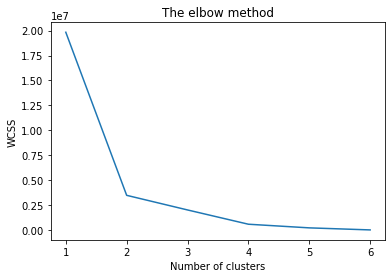

In [13]:
import commonmethods.image_modification as im

wcss = []   #within cluster sum of squares

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

for k in range(1, len(values)+1):
    compactness, _, _ = cv2.kmeans(values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    wcss.append(compactness)

plt.plot(range(1, len(values)+1), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [31]:
import commonmethods.image_modification as im
import commonmethods.optimal_cluster_number as ocn

#the best value and the cluster which resulted
s_closest = [0, 2]
db_min = [1000000, 2]
ch_max = [0, 2]

for i in range(2, len(values)):
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    _, labels, _ = cv2.kmeans(values, i, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    labels = labels.flatten()
    print(labels)

    s_time, s_score = ocn.silhouette_method(values, labels)
    db_time, db_score = ocn.davies_bouldin_method(values, labels)
    ch_time, ch_score = ocn.calinski_harabasz_method(values, labels)
    
    print("k: {}, S: {}, DB: {}, CH: {}".format(i, s_score, db_score, ch_score))
    
    #get the best cluster number for each methods
    if((1-s_score) < (1-s_closest[0])):
        s_closest = [s_score, i]

    if(db_score < db_min[0]):
        db_min = [db_score, i]

    if(ch_score > ch_max[0]):
        ch_max = [ch_score, i]
        
print(s_closest)
print(db_min)
print(ch_max)

[1 1 1 0 0 0]
k: 2, S: 0.6031238436698914, DB: 0.419121436429263, CH: 18.861300486900472
[0 0 1 2 2 2]
k: 3, S: 0.40283751487731934, DB: 0.35098723820579464, CH: 13.351915565117537
[1 1 3 0 0 2]
k: 4, S: 0.3056747019290924, DB: 0.25750165778287426, CH: 22.49276223056854
[0 3 2 4 4 1]
k: 5, S: 0.18032801151275635, DB: 0.14009845755335873, CH: 23.824592623771387
[0.60312384, 2]
[0.14009845755335873, 5]
[23.824592623771387, 5]


## Get frames diagonally

In [61]:
def get_frame_values(frame_num, xy, px):
    pixels = np.zeros((frame_num, 2))
    for i in range(frame_num):
        frame = get_frame(xy, xy)
        frame = frame.reshape((1, -1))
        pixels[i] = [xy, xy]
        
        if i == 0:
            result = np.array(frame)
        else:
            result = np.vstack([result, frame])
            
        xy = xy + px
    
    return result, pixels

In [67]:
def color_frames(image, lables, pixels, px):
    colored_image = image
    colors = np.array([[0, 0, 135],[255, 0, 0], [255, 255, 0],[255, 0, 127],[0, 255, 0]])
    
    for i in range(len(labels)):
        colored_image[int(pixels[i][0]):int(pixels[i][0]+px), int(pixels[i][1]):int(pixels[i][1]+px)] = (255, 0, 0)
    
    return colored_image

In [79]:
import cv2
from matplotlib import pyplot as plt

px = 16
xy = 0
height, width = resized_image.shape

h_num = int(height / px)
w_num = int(width / px)
diff = abs(h_num - w_num)

if(h_num == w_num):
    frame_values, pixels = get_frame_values(h_num, xy, px)
else:
    if(h_num > w_num):
        frame_values, pixels = get_frame_values(w_num, xy, px)
    else:
        frame_values, pixels = get_frame_values(h_num, xy, px)

frame_values = np.float32(frame_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 5
_, labels, (centers) = cv2.kmeans(frame_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

print(frame_values)

cl_image = color_frames(resized_image, labels.flatten(), pixels, px)

plt.axis("off")

plt.imshow(cl_image)

[[  0.   0.   0. ...   1.   1.   1.]
 [  1.   1.   1. ...   0.   0.   0.]
 [  0.   0.   0. ...   1.   1.   1.]
 ...
 [199. 199. 199. ... 201. 201. 201.]
 [188. 188. 188. ... 119. 119. 119.]
 [120. 120. 120. ... 100. 100. 100.]]


ValueError: could not broadcast input array from shape (3) into shape (16,16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(312, 312, 3)


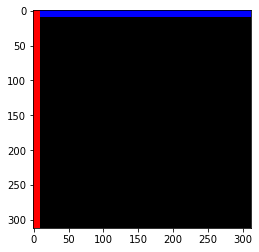

In [72]:
x = np.zeros((312, 312,3), dtype=np.float32)

x[0:10,:] = (0,0,255) # red
x[:,0:10] = (255,0,0) # blue

print(x.shape)

plt.imshow(x)